In [1]:
from dataclasses import dataclass

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams["figure.autolayout"] = True

In [2]:
from paths_image import PathsImage

@dataclass
class Path:
    name: str
    xyz: np.array
    lat: np.array
    lon: np.array
    sections = property(lambda self: self.lat.shape[0])

PATHS: dict[str, Path] = {}

R_EQUAT = 2440.5  # Equatorial radius (semi-major)
R_POLAR = 2438.3  # Polar radius (semi-minor)
R_CIRC = (R_EQUAT + R_POLAR) / 2  # Radius to use for circular calcs

for path_name, raw_points in PathsImage.PATHS.items():
    points = np.array(raw_points).T

    # Centre x-y and flip y b/c pixels go downwards
    points[0] -= PathsImage.CENTRE[0]
    points[1] = -(points[1] - PathsImage.CENTRE[1])
    # Scale from pixels to kilometres
    points = points * (R_CIRC / PathsImage.RADIUS)

    # Convert from x-y to latitude, longitude
    lat_rad = -np.arccos(np.hypot(points[0], points[1]) / R_CIRC)
    lon_rad = np.arctan2(points[1], points[0])
    lat, lon = np.rad2deg(lat_rad), np.rad2deg(lon_rad)

    # Save for later
    xyz = np.array([points[0], points[1], R_CIRC * np.sin(lat_rad)])
    path = Path(path_name, xyz, lat, lon)
    PATHS[path_name] = path

## Plot Path x-y Coordinates

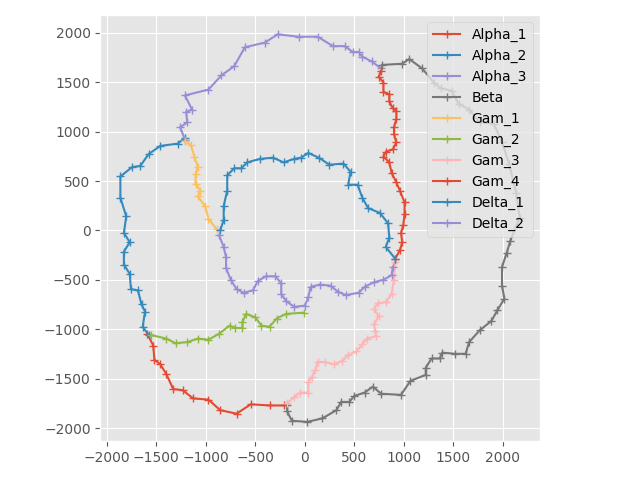

In [3]:
fig, ax = plt.subplots(1)
ax.set_aspect("equal")

for name, path in PATHS.items():
    ax.plot(path.xyz[0], path.xyz[1], "-+", label=name)
    # ax[0].plot(path.lat, "-+", label=name)
    # ax[1].plot(path.lon, "-+", label=name)

ax.legend()

## Plot 3D Plot of Paths

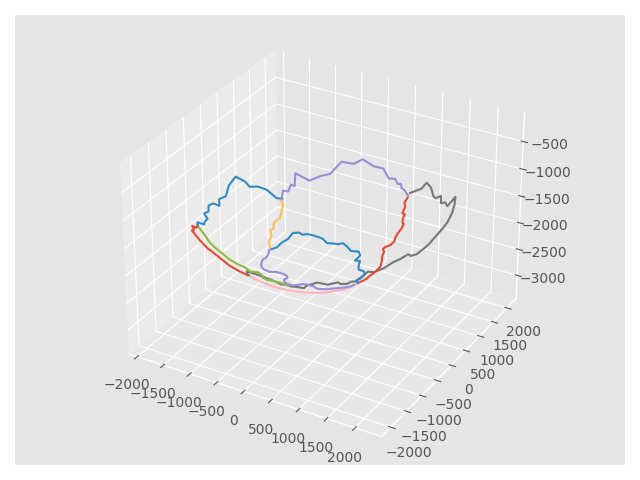

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for name, path in PATHS.items():
    ax.plot3D(path.xyz[0], path.xyz[1], path.xyz[2])

ax.set_aspect("equal")

## Total Path Distance

In [5]:
def haversine_distance(lat_1, lon_1, lat_2, lon_2):
    lat_1, lon_1 = np.deg2rad(lat_1), np.deg2rad(lon_1)
    lat_2, lon_2 = np.deg2rad(lat_2), np.deg2rad(lon_2)
    a = np.sin((lat_2 - lat_1) / 2) ** 2
    b = np.sin((lon_2 - lon_1) / 2) ** 2
    c = (a + b * np.cos(lat_1) * np.cos(lat_2))
    return R_CIRC * 2 * np.arctan2(np.sqrt(c), np.sqrt(1 - c))

def total_path_distance(path):
    tot_d = 0
    for i in range(1, path.sections):
        d = haversine_distance(path.lat[i - 1], path.lon[i - 1], path.lat[i], path.lon[i])
        tot_d += d
    return tot_d

print("Total Path Distances:")
for name, path in PATHS.items():
    tot_d = total_path_distance(path)
    print(f"  {name}: {tot_d:.2f} [km]")

Total Path Distances:
  Alpha_1: 2080.87 [km]
  Alpha_2: 2832.25 [km]
  Alpha_3: 3192.52 [km]
  Beta: 7156.76 [km]
  Gam_1: 1090.75 [km]
  Gam_2: 2031.66 [km]
  Gam_3: 2327.25 [km]
  Gam_4: 2295.36 [km]
  Delta_1: 3162.74 [km]
  Delta_2: 2787.36 [km]


## Terminator Speed

According to the RFP, the terminator moves at 3.63 km/h. A solar day on Mercury is 175.94 Earth days. The average longitudinal speed of the terminator is then approximately 0.08525 degrees per hour. We can calculate the time that the terminator will take to traverse a path using the min to max of longitudes achieved on a path.

In [6]:
TERM_LON_SPEED = (360 / 175.94)  # deg / day

print("Terminator Sweep Times:")
for name, path in PATHS.items():
    lon_range = np.ptp(np.unwrap(path.lon, period=360))
    term_time = (lon_range / TERM_LON_SPEED)  # days
    print(f"  {name}: {term_time} [Earth days]")

Terminator Sweep Times:
  Alpha_1: 24.347250880202207 [Earth days]
  Alpha_2: 34.966853200410355 [Earth days]
  Alpha_3: 38.20433912171569 [Earth days]
  Beta: 78.52058975607882 [Earth days]
  Gam_1: 17.69193545103469 [Earth days]
  Gam_2: 26.874725271417688 [Earth days]
  Gam_3: 37.388793243729616 [Earth days]
  Gam_4: 39.961149600024406 [Earth days]
  Delta_1: 96.43058615664017 [Earth days]
  Delta_2: 75.46198683618263 [Earth days]


## Required Traverse Speed

Required Path Traverse Speed (Mean, Max):
  Alpha_1: 1.021, 1.832 [m/s]
  Alpha_2: 0.997, 2.206 [m/s]
  Alpha_3: 1.081, 3.757 [m/s]
  Beta: 1.407, 11.257 [m/s]
  Gam_1: 1.381, 7.484 [m/s]
  Gam_2: 1.123, 2.750 [m/s]
  Gam_3: 2.519, 38.336 [m/s]
  Gam_4: 1.431, 15.736 [m/s]
  Delta_1: 0.395, 0.646 [m/s]
  Delta_2: 0.491, 1.228 [m/s]


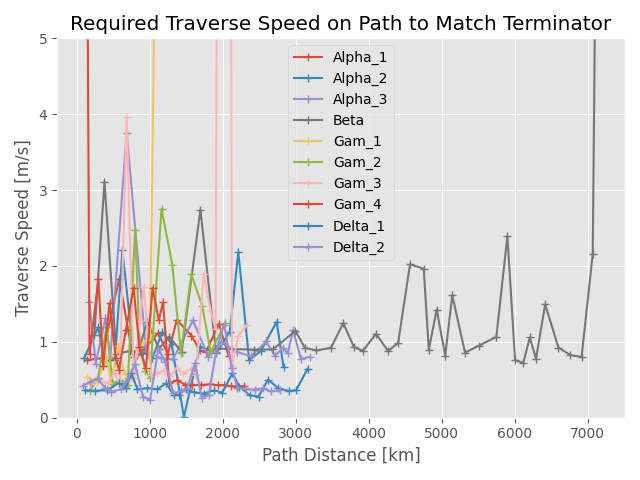

In [7]:
print("Required Path Traverse Speed (Mean, Max):")
fig, ax = plt.subplots()

for name, path in PATHS.items():
    dists = []  # km
    req_speeds = []  # m / s

    for i in range(1, path.sections):
        delta_lon = np.abs(path.lon[i] - path.lon[i - 1])
        term_time = (delta_lon / TERM_LON_SPEED)

        path_dist = haversine_distance(path.lat[i - 1], path.lon[i - 1], path.lat[i], path.lon[i])
        req_speed = (path_dist / term_time)  # km / days
        req_speed_ms = (req_speed * 1000 / (24 * 60 * 60))

        dists.append(path_dist)
        req_speeds.append(req_speed_ms)

    req_speeds = np.array(req_speeds)
    print(f"  {name}: {np.mean(req_speeds):.3f}, {np.max(req_speeds):.3f} [m/s]")

    ax.plot(np.cumsum(dists), req_speeds, "-+", label=name)

ax.set_ylim(0, 5)
ax.set_xlabel("Path Distance [km]")
ax.set_ylabel("Traverse Speed [m/s]")
ax.set_title("Required Traverse Speed on Path to Match Terminator")
ax.legend()